**This experiment investigates the overall effect of class weighting on performance**

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 1: Import Dependencies

In [ ]:
!pip install tensorflow
!pip install livelossplot
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(42)
plt.style.use("ggplot")
import tensorflow as tf

Import relevant functions from the utilities.py file

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Natural_Language_Processing')

from utilities import SentanceGetter, preprocess_data, preprocess_data2, evaluate_model, show_random_example

### 2: Dataset Loading and Preparation

TAGS:
- B-AC signifies that token is an abbreviation/acronym
- B-LF signifies that a long form ‘begins’ with this token.
- I-LF label signifies that the token is ‘inside’ of a long form.
- B-O (or ‘O’) indicate other tokens which are neither abbreviations nor long forms.
- PAD - added later, represents padding.

In [ ]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Natural_Language_Processing/combined_train_data.csv'
data = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print(data.head())

   index   Sentence #        Word    POS   Tag
0      0  Sentence: 1         For    ADP   B-O
1      0          NaN        this    DET   B-O
2      0          NaN     purpose   NOUN   B-O
3      0          NaN         the    DET   B-O
4      0          NaN  Gothenburg  PROPN  B-LF


In [ ]:
#Looking for null values
print(data.isnull().sum())

index             0
Sentence #    48649
Word              5
POS               0
Tag               0
dtype: int64


In [ ]:
#Filling Null Values (if any)
train_data = data.fillna(method='ffill')
train_data.head()

,index,Sentence #,Word,POS,Tag
0,0,Sentence: 1,For,ADP,B-O
1,0,Sentence: 1,this,DET,B-O
2,0,Sentence: 1,purpose,NOUN,B-O
3,0,Sentence: 1,the,DET,B-O
4,0,Sentence: 1,Gothenburg,PROPN,B-LF


In [ ]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 10587
Unique Tag in corpus: 4


In [ ]:
#Storing unique words and tags as a list
words = list(set(train_data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
words[len(words)-1]

'ENDPAD'

In [ ]:
tags = list(set(train_data['Tag'].values))
num_tags = len(tags)

In [ ]:
tags = ['PAD','B-AC', 'I-LF', 'B-O', 'B-LF']

In [ ]:
num_words, num_tags

(10588, 4)

### 3: Retrieve Sentences/Token sequences

In [ ]:
getter = SentanceGetter(train_data)
sentances = getter.sentances

Confirm data appears in the correct format

In [ ]:
sentances[0][0:15]

[('For', 'ADP', 'B-O'),
 ('this', 'DET', 'B-O'),
 ('purpose', 'NOUN', 'B-O'),
 ('the', 'DET', 'B-O'),
 ('Gothenburg', 'PROPN', 'B-LF'),
 ('Young', 'PROPN', 'I-LF'),
 ('Persons', 'PROPN', 'I-LF'),
 ('Empowerment', 'PROPN', 'I-LF'),
 ('Scale', 'PROPN', 'I-LF'),
 ('(', 'PUNCT', 'B-O'),
 ('GYPES', 'PROPN', 'B-AC'),
 (')', 'PUNCT', 'B-O'),
 ('was', 'AUX', 'B-O'),
 ('developed', 'VERB', 'B-O'),
 ('.', 'PUNCT', 'B-O')]

### 4: Mappings between Sentences and NER Tags

In [ ]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx = {
    "PAD": 0,  # Padding value
    "B-O": 1,  # Valid class
    "B-AC": 2,  # Valid class
    "B-LF": 3,  # Valid class
    "I-LF": 4  # Valid class
}


In [ ]:
word2idx

### 5: Padding Input Sentences and Creating Train/Test Splits


In [ ]:
num_tags = len(tag2idx)

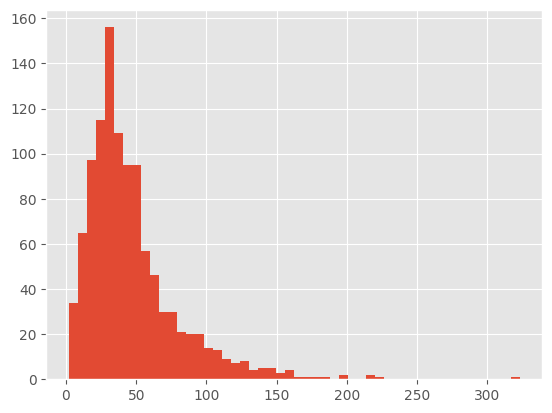

In [ ]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from utilities import preprocess_data2

max_len = 50
padding_value = word2idx["ENDPAD"]

X, y = preprocess_data(sentances, word2idx, tag2idx, max_len, num_words, num_tags)

Original test set size = 126

Validation Set Size = 153

In [ ]:
tag2idx["PAD"]

0

In [ ]:
test_proportion = (126*0.2)/215
validation_proportion = (153*0.2)/215

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=test_proportion, random_state=1)

### 6: Bidirectional LSTM Model

Define Class Weights

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Convert y_train from one-hot encoding to class indices
y_train_classes = np.argmax(y_train, axis=-1).flatten()

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)

# Create a dictionary for class weights
class_weight_dict = dict(zip(np.unique(y_train_classes), class_weights))

In [ ]:
y_train_classes[0:25]

array([1, 3, 4, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0])

In [ ]:
class_weights

array([0.70350264, 0.33687059, 4.92451848, 7.85714286, 3.57520786])

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model

# Define input and parameters
input_word = Input(shape=(max_len,))
#masking_value = 4  # Use the same value as the padding in your data preparation

# Define Embedding layer with mask_value
model = Embedding(input_dim=num_words+1, output_dim=max_len, input_length=max_len, mask_zero=True)(input_word)

# Add SpatialDropout1D
model = SpatialDropout1D(0.1)(model)

# Add Bidirectional LSTM
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Add TimeDistributed Dense layer with softmax activation
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

# Create the model
model = Model(inputs=input_word, outputs=out)

# Print model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            529450    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 50, 50)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 200)           120800    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 50, 5)             1005      
 stributed)                                                      
                                                           

In [ ]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

## 7: Training and Evaluation (Base Model)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

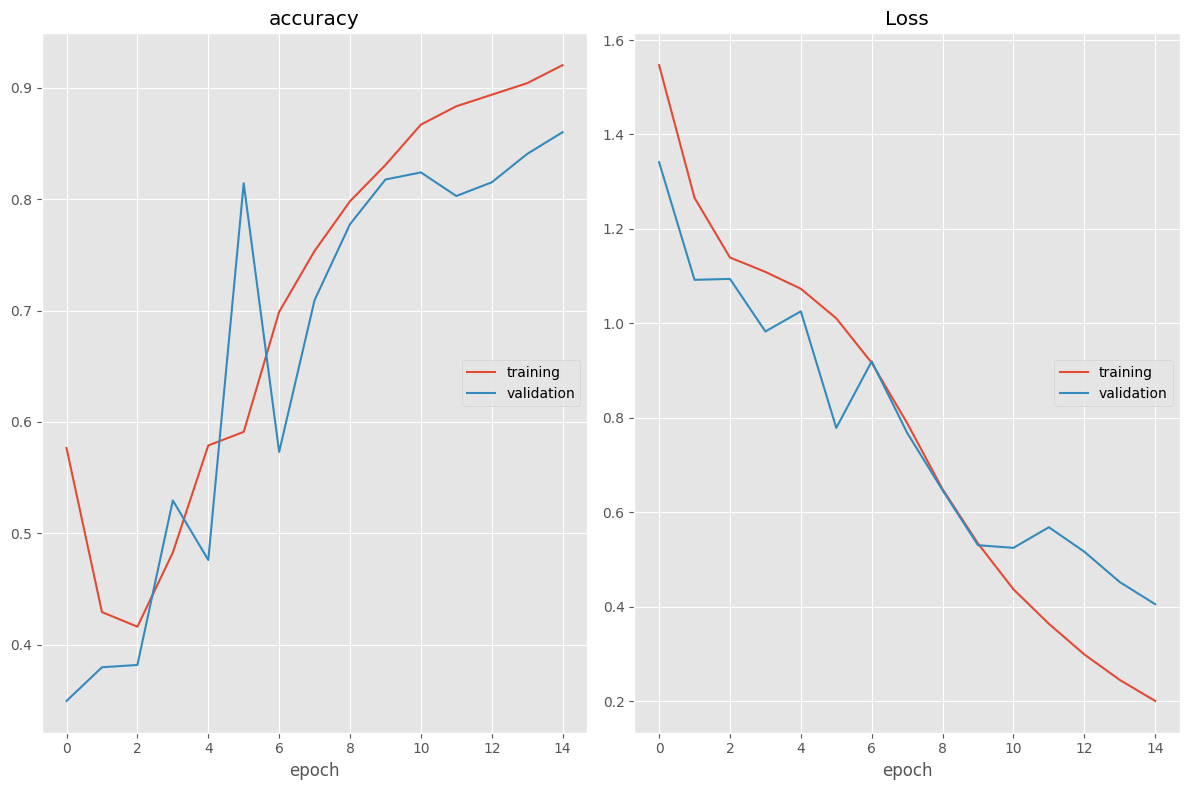

accuracy
	training         	 (min:    0.416, max:    0.920, cur:    0.920)
	validation       	 (min:    0.349, max:    0.860, cur:    0.860)
Loss
	training         	 (min:    0.200, max:    1.547, cur:    0.200)
	validation       	 (min:    0.405, max:    1.341, cur:    0.405)
13/13 [==============================] - 4s 281ms/step - loss: 0.2004 - accuracy: 0.9203 - val_loss: 0.4052 - val_accuracy: 0.8601


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=4,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = validation_proportion,
    batch_size = 64,
    class_weight=class_weight_dict,
    epochs = 15,
    verbose = 1,
    callbacks=callbacks

    )

Evaluate The Model

4/4 [==============================] - 1s 56ms/step


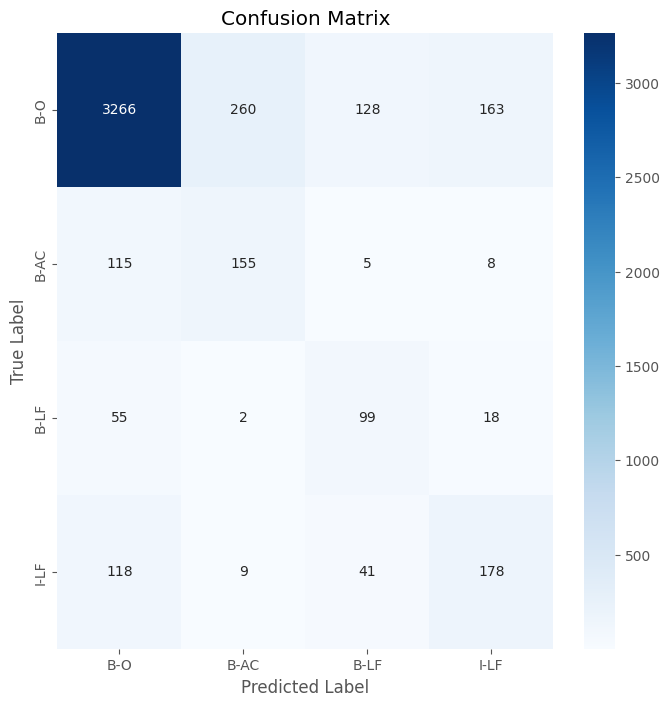

Class	Precision	Recall	F1 Score
-----------------------------------
B-O	0.9190	0.8556	0.8862
B-AC	0.3638	0.5477	0.4372
B-LF	0.3626	0.5690	0.4430
I-LF	0.4850	0.5145	0.4993

Weighted F1 score: 0.8130
Macro F1 score: 0.5664


In [ ]:
class_mapping = {0:'PAD', 1: 'B-O', 2: 'B-AC', 3: 'B-LF', 4: 'I-LF'}

evaluate_model(model, x_test, y_test, class_mapping, plot_title='Confusion Matrix', plot_size=(8, 8))

Observe random predictions and their true labels for further error analysis.

In [ ]:
tags = ['PAD','B-O', 'B-AC', 'B-LF', 'I-LF']
show_random_example(model, x_test, y_test, words, tags, random_state=1)

1/1 [==============================] - 0s 35ms/step
Word           True 	 Pred

------------------------------
Ischaemia      B-O  	B-LF
-              B-O  	I-LF
reperfusion    B-O  	B-O
injury         B-O  	B-O
in             B-O  	B-O
kidney         B-O  	B-O
transplantationB-O  	B-O
leads          B-O  	B-O
to             B-O  	B-O
delayed        B-LF 	B-O
graft          I-LF 	B-O
function       I-LF 	B-O
(              B-O  	B-O
DGF            B-AC 	B-O
)              B-O  	B-O
,              B-O  	B-O
which          B-O  	B-O
is             B-O  	B-O
associated     B-O  	B-O
with           B-O  	B-O
reduced        B-O  	B-O
long           B-O  	B-O
term           B-O  	B-O
graft          B-O  	B-O
function       B-O  	B-O
.              B-O  	B-O
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD         PAD  	PAD
ENDPAD      